# Notebook 13 a) Aspect Prediction with Machine Learning Models

This notebook investigates predictive models for the aspects part of the review data based on the extracted nouns using ML models. The output is therefore multiclass.

* Section 1 - Import libraries and dataset
* Section 2 - Pre-processing
* Section 3 - Run models
* Section 4 - Prediction on validation set

Dataset:
* combinedaspectcheck.xlsx

# Section 1: Import libraries and data

In [358]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

In [359]:
df_accom = pd.read_excel('combinedaspectcheck.xlsx',sheet_name = 'CLEANEDACCOM')
df_food = pd.read_excel("combinedaspectcheck.xlsx",sheet_name = "CLEANEDFOOD")
df_attract = pd.read_excel("combinedaspectcheck.xlsx", sheet_name = "CLEANEDATTRACT")

In [360]:
df_accom.head()

,OrigInd,Category,Cleaned,Noun Phrases,Nouns,Aspect,Sentiment
0,2030,Accommodation,main complaint room made u feel ill,main complaint room,complaint room,Room,-0.2960
1,10751,Accommodation,weekend away staff great room clean shower goo...,great room,room,Room,0.6249
2,11247,Accommodation,great room breakfast fabulous central location,great room breakfast fabulous,room breakfast,Room,0.8176
3,21902,Accommodation,shower great size well toiletry clean towel pr...,clean towel,towel,Room,0.4019
4,22835,Accommodation,great bed breakfast stayed week encore guest h...,lovely clean room facility,room facility,Room,0.7579


# Section 2: Pre-processing

In [361]:
# Drop column
df_accom.drop(["Category"],axis = 1, inplace = True)
df_food.drop(["Category"],axis = 1,inplace = True)
df_attract.drop(["Category"],axis = 1,inplace = True)

In [362]:
# Set to title case as some categories are multiples
df_accom["Aspect"] = df_accom["Aspect"].apply(lambda x: x.title())

In [363]:
df_accom["Aspect"].value_counts()

Room             350
Staff            350
Hotel            350
Entertainment    350
Food             350
Value            250
Location         220
Name: Aspect, dtype: int64

In [364]:
df_food["Aspect"].value_counts()

Food Quality     350
Visit Exp        350
Meal Exp         350
Menu Choice      350
Value            350
Staff&Service    350
Name: Aspect, dtype: int64

In [365]:
df_attract["Aspect"].value_counts()

Activities       300
Amenities        300
Nature           300
VisitExp&Gen     250
Staff&Service    200
History          150
Value            150
Name: Aspect, dtype: int64

In [366]:
# Function to specify X and y
def XY(df):
    X = df["Nouns"]
    y = df["Aspect"]

    return X,y

In [367]:
# Apply function and print shape
X_accom,y_accom = XY(df_accom)
X_food,y_food = XY(df_food)
X_attract,y_attract = XY(df_attract)

print(X_accom.shape,y_accom.shape)
print(X_food.shape,y_food.shape)
print(X_attract.shape,y_attract.shape)


(2220,) (2220,)
(2100,) (2100,)
(1650,) (1650,)


In [401]:
# Train, validation split
def train_test(X,y):
    X_train, X_val, y_train, y_val = train_test_split(X,y, stratify = y,test_size=0.20, shuffle = True)
    return X_train,X_val,y_train,y_val

In [402]:
# Run function
X_train_accom,X_val_accom,y_train_accom,y_val_accom = train_test(X_accom,y_accom)
X_train_food,X_val_food,y_train_food,y_val_food = train_test(X_food,y_food)
X_train_attract,X_val_attract,y_train_attract,y_val_attract = train_test(X_attract,y_attract)

In [403]:
# Shape of training, validation and test sets for each category
print(X_train_accom.shape, X_val_accom.shape, y_train_accom.shape, y_val_accom.shape)
print(X_train_food.shape, X_val_food.shape, y_train_food.shape, y_val_food.shape)
print(X_train_attract.shape,X_val_attract.shape, y_train_attract.shape, y_val_attract.shape)

(1776,) (444,) (1776,) (444,)
(1680,) (420,) (1680,) (420,)
(1320,) (330,) (1320,) (330,)


In [404]:
# TFIDF vectorizer function
def vec(X_train, X_val):
    vect = TfidfVectorizer(use_idf = True, max_df = 1.0, min_df = 1, stop_words = "english", 
                           ngram_range = (1,1),smooth_idf = True, norm = 'l2')
    vect.fit(X_train)
    X_train_tfidf = vect.transform(X_train)
    X_val_tfidf = vect.transform(X_val)
    return X_train_tfidf, X_val_tfidf

In [405]:
# Run function
X_train_accom_tfidf, X_val_accom_tfidf = vec(X_train_accom, X_val_accom)
X_train_food_tfidf, X_val_food_tfidf = vec(X_train_food, X_val_food)
X_train_attract_tfidf, X_val_attract_tfidf = vec(X_train_attract, X_val_attract)

In [406]:
# Function to encode y values as integer labels (necessary for stratified cross validation as one-hot encoded doesn't work)
def lab(y_train, y_val):
    le = preprocessing.LabelEncoder()
    y_train_l = le.fit_transform(y_train)
    y_val_l = le.transform(y_val)
    return y_train_l, y_val_l

In [407]:
# Apply functions
y_train_accom_l, y_val_accom_l = lab(y_train_accom, y_val_accom)
y_train_food_l, y_val_food_l = lab(y_train_food, y_val_food)
y_train_attract_l, y_val_attract_l = lab(y_train_attract, y_val_attract)

In [408]:
X_train_accom_tfidf

<1776x793 sparse matrix of type '<class 'numpy.float64'>'
	with 3605 stored elements in Compressed Sparse Row format>

In [409]:
# Stratified K Fold
def strat(model, X_train,y_train,vector):
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    cv_results = cross_val_score(model, X_train,y_train, cv=kfold)
    mean = cv_results.mean()
    df = pd.DataFrame({vector:mean},index = [0])
    return df

# Section 3: Run models

In [410]:
# Define models
clf1 = MultinomialNB()
clf2 = LogisticRegression(random_state=0, class_weight = "balanced")
clf3 = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0, class_weight = "balanced")
clf4 = LinearSVC(class_weight = "balanced")

In [411]:
ac1 = strat(clf1, X_train_accom_tfidf, y_train_accom_l,"NB")
f1 = strat(clf1, X_train_food_tfidf, y_train_food_l,"NB")
t1 = strat(clf1, X_train_attract_tfidf, y_train_attract_l,"NB")

In [412]:
ac2 = strat(clf2, X_train_accom_tfidf, y_train_accom_l,"LR")
f2 = strat(clf2, X_train_food_tfidf, y_train_food_l,"LR")
t2 = strat(clf2, X_train_attract_tfidf, y_train_attract_l,"LR")

In [413]:
ac3 = strat(clf3, X_train_accom_tfidf, y_train_accom_l,"RF")
f3 = strat(clf3, X_train_food_tfidf, y_train_food_l,"RF")
t3 = strat(clf3, X_train_attract_tfidf, y_train_attract_l,"RF")

In [414]:
ac4 = strat(clf4, X_train_accom_tfidf, y_train_accom_l,"SVM")
f4 = strat(clf4, X_train_food_tfidf, y_train_food_l,"SVM")
t4 = strat(clf4, X_train_attract_tfidf, y_train_attract_l,"SVM")

In [415]:
# Training accuracies all models
models = ["Accom","Food","Attract"]
a = pd.concat([ac1,ac2,ac3,ac4],axis = 1)
b = pd.concat([f1,f2,f3,f4],axis = 1)
c = pd.concat([t1,t2,t3,t4],axis = 1)
all_models = pd.concat([a,b,c],axis = 0)
all_models.set_index([models],inplace = True)
all_models

,NB,LR,RF,SVM
Accom,0.913848,0.924554,0.871624,0.925674
Food,0.932143,0.955952,0.945833,0.960119
Attract,0.819697,0.841667,0.747727,0.849242


# Section 4: Prediction on validation set of best model

In [416]:
def prediction(model,X_train,y_train,X_val,y_val,labels):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_val)
    print(classification_report(y_val, y_pred))
    conf_mat = confusion_matrix(y_val, y_pred)
    fig, ax = plt.subplots(figsize=(10,8))
    ax = sns.heatmap(conf_mat, annot=True, fmt='d',
                     xticklabels=labels, yticklabels=labels)
    ax.set_ylabel('Actual',labelpad = 10)
    ax.set_xlabel('Predicted', labelpad = 13)
    plt.show()


In [417]:
labels_accom = ["Entertainment","Food","Hotel","Location","Room","Staff","Value"]
labels_food = ["Food Quality","Meal Exp","Menu Choice","Staff","Value","Visit Exp",""]
labels_attract= ["Activities","Amenities","History","Nature","Staff/Service","Value","VisitGen"]

## Accommodation

              precision    recall  f1-score   support

           0       0.82      0.94      0.88        70
           1       1.00      0.94      0.97        70
           2       0.99      0.99      0.99        70
           3       0.98      0.93      0.95        44
           4       0.93      0.89      0.91        70
           5       0.97      0.97      0.97        70
           6       0.98      0.96      0.97        50

    accuracy                           0.95       444
   macro avg       0.95      0.95      0.95       444
weighted avg       0.95      0.95      0.95       444



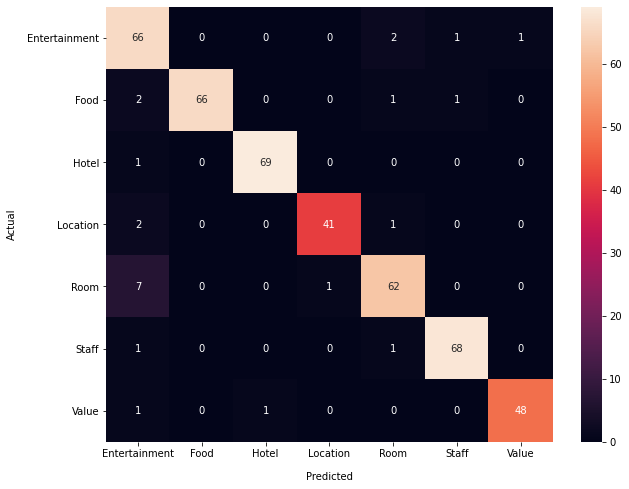

In [418]:
prediction(clf4,X_train_accom_tfidf,y_train_accom_l,X_val_accom_tfidf,y_val_accom_l,labels_accom)

Analysis:
* Model performs quite well but the 'Food' category has quite a few misclassifications as 'Entertainment'

In [419]:
# Get df of aspects and their respective codes
df_accom = pd.concat([pd.DataFrame(y_val_accom).reset_index(),pd.DataFrame(y_val_accom_l).reset_index()],axis = 1,ignore_index = True)
df_accom=df_accom[[1,3]]

# Fit best model to training, predict on validation
clf4.fit(X_train_accom_tfidf,y_train_accom_l)
y_pred_accom = pd.DataFrame(clf4.predict(X_val_accom_tfidf))

# Compare actual and predicted
compare_accom = pd.concat([df_accom,y_pred_accom],axis = 1,ignore_index = True)
compare_accom.columns = ["Aspect","Integer","Predicted"]
wrong_accom = compare_accom[compare_accom["Integer"]!=compare_accom["Predicted"]]
wrong_accom.Aspect.value_counts()

Room             8
Food             4
Entertainment    4
Location         3
Value            2
Staff            2
Hotel            1
Name: Aspect, dtype: int64

In [437]:
wrong_accom[wrong_accom["Aspect"] == "Food"]

,Aspect,Integer,Predicted
130,Food,1,0
236,Food,1,4
271,Food,1,0
343,Food,1,5


Misclassified mostly as Entertainment

In [438]:
print(X_val_accom.iloc[130])
print(X_val_accom.iloc[236])
print(X_val_accom.iloc[271])
print(X_val_accom.iloc[343])

flavour
decor table
chicken
quality quantity complaint


In [439]:
wrong_accom[wrong_accom["Aspect"] == "Room"]

,Aspect,Integer,Predicted
48,Room,4,0
65,Room,4,3
77,Room,4,0
82,Room,4,0
95,Room,4,0
172,Room,4,0
269,Room,4,0
409,Room,4,0


In [440]:
print(X_val_accom.iloc[48])
print(X_val_accom.iloc[77])
print(X_val_accom.iloc[82])
print(X_val_accom.iloc[95])

prestige
grid
area
course temple toiletry addition


Analysis:
* The items the model got wrong are words which are unclear. This highlights the problems with using just one noun to categorise a row with an aspect.

## Food

              precision    recall  f1-score   support

           0       0.98      0.91      0.95        70
           1       0.81      0.91      0.86        70
           2       0.99      0.96      0.97        70
           3       0.95      1.00      0.97        70
           4       0.96      0.96      0.96        70
           5       0.92      0.84      0.88        70

    accuracy                           0.93       420
   macro avg       0.93      0.93      0.93       420
weighted avg       0.93      0.93      0.93       420



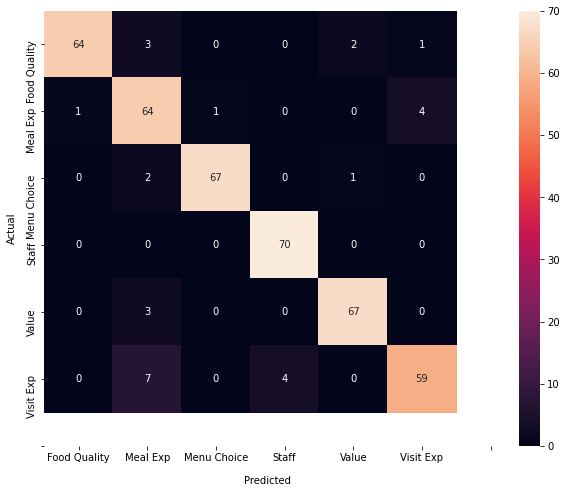

In [424]:
prediction(clf4,X_train_food_tfidf,y_train_food_l,X_val_food_tfidf,y_val_food_l,labels_food)

In [425]:
# Get df of aspects and their respective codes
df_food = pd.concat([pd.DataFrame(y_val_food).reset_index(),pd.DataFrame(y_val_food_l).reset_index()],axis = 1,ignore_index = True)
df_food=df_food[[1,3]]

# Fit best model to training, predict on validation
clf4.fit(X_train_food_tfidf,y_train_food_l)
y_pred_food = pd.DataFrame(clf4.predict(X_val_food_tfidf))

# Compare actual and predicted
compare_food = pd.concat([df_food,y_pred_food],axis = 1,ignore_index = True)
compare_food.columns = ["Aspect","Integer","Predicted"]
wrong_food = compare_food[compare_food["Integer"]!=compare_food["Predicted"]]
wrong_food.Aspect.value_counts()

Visit Exp       11
Food Quality     6
Meal Exp         6
Value            3
Menu Choice      3
Name: Aspect, dtype: int64

The meal and visit experiences are fuzzy categories, might be better to combine these?

In [426]:
wrong_food[wrong_food["Aspect"] == "Visit Exp"]

,Aspect,Integer,Predicted
13,Visit Exp,5,1
99,Visit Exp,5,1
120,Visit Exp,5,3
166,Visit Exp,5,3
177,Visit Exp,5,1
251,Visit Exp,5,3
254,Visit Exp,5,1
283,Visit Exp,5,1
288,Visit Exp,5,1
318,Visit Exp,5,1


In [427]:
print(X_val_accom.iloc[64])
print(X_val_accom.iloc[221])
print(X_val_accom.iloc[346])

staff
rise refund
flawless bathroom mould


In [428]:
wrong_food[wrong_food["Aspect"] == "Meal Exp"]

,Aspect,Integer,Predicted
23,Meal Exp,1,0
60,Meal Exp,1,2
67,Meal Exp,1,5
157,Meal Exp,1,5
159,Meal Exp,1,5
376,Meal Exp,1,5


Analysis:
* The two aspects are getting mixed up
* A particular issue with the food category is that the reviews are short and there are mixed aspects, the lines were labelled based on just the first aspect, so some aspects will be missed.

## Attractions

              precision    recall  f1-score   support

           0       0.91      0.83      0.87        60
           1       0.86      0.90      0.88        60
           2       0.90      0.87      0.88        30
           3       0.91      0.80      0.85        60
           4       0.93      0.93      0.93        40
           5       0.82      0.93      0.87        30
           6       0.70      0.78      0.74        50

    accuracy                           0.85       330
   macro avg       0.86      0.86      0.86       330
weighted avg       0.86      0.85      0.86       330



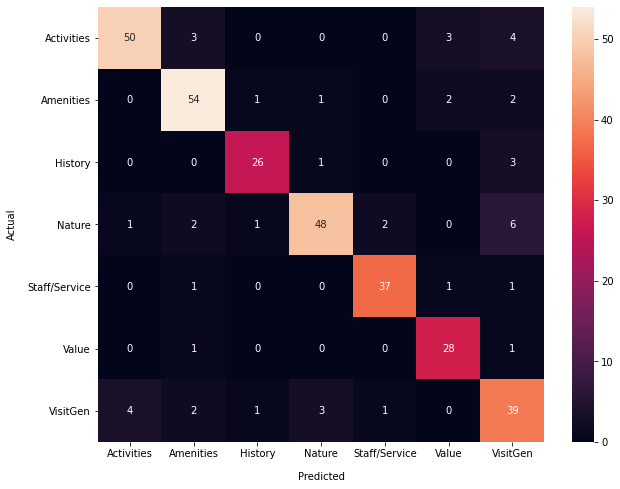

In [429]:
prediction(clf4,X_train_attract_tfidf,y_train_attract_l,X_val_attract_tfidf,y_val_attract_l,labels_attract)

There are some significant problems with some of the aspects being classified as 'Visit General' including 'Nature', 'Activities' and 'Amenities'. This is likely due to the classification of the training set itself. Looking at where the model went wrong.

In [430]:
# Get df of aspects and their respective codes
df_attract = pd.concat([pd.DataFrame(y_val_attract).reset_index(),pd.DataFrame(y_val_attract_l).reset_index()],axis = 1,ignore_index = True)
df_attract=df_attract[[1,3]]

In [431]:
# Fit best model to training, predict on validation
clf4.fit(X_train_attract_tfidf,y_train_attract_l)
y_pred_attract = pd.DataFrame(clf4.predict(X_val_attract_tfidf))

In [432]:
# Compare actual and predicted
compare = pd.concat([df_attract,y_pred_attract],axis = 1,ignore_index = True)
compare.columns = ["Aspect","Integer","Predicted"]
wrong = compare[compare["Integer"]!=compare["Predicted"]]
wrong.Aspect.value_counts()

Nature           12
VisitExp&Gen     11
Activities       10
Amenities         6
History           4
Staff&Service     3
Value             2
Name: Aspect, dtype: int64

In [433]:
wrong[wrong["Aspect"]=="Nature"]

,Aspect,Integer,Predicted
14,Nature,3,6
60,Nature,3,0
110,Nature,3,6
115,Nature,3,6
122,Nature,3,1
133,Nature,3,2
134,Nature,3,6
145,Nature,3,6
163,Nature,3,4
211,Nature,3,4


The categories are being misclassified as 'Visit General'

In [441]:
print(X_val_attract.iloc[14])
print(X_val_attract.iloc[110])
print(X_val_attract.iloc[115])
print(X_val_attract.iloc[134])

air
amount work worldwide
tawney owl
spring sunshine


In [442]:
wrong[wrong["Aspect"]=="Activities"]

,Aspect,Integer,Predicted
62,Activities,0,1
68,Activities,0,6
78,Activities,0,6
117,Activities,0,1
155,Activities,0,1
185,Activities,0,5
216,Activities,0,5
249,Activities,0,6
258,Activities,0,5
262,Activities,0,6


In [445]:
print(X_val_attract.iloc[62])
print(X_val_attract.iloc[68])
print(X_val_attract.iloc[185])

selection movie
act
adventure golf value money


Analysis:
It seems as though the model is really struggling, possibly because there are just too many varied words in the attractions category for the model to learn. Much more data is likely needed to train a model. Also the single nouns do not perhaps provide enough information for this category, compared to say 'food' where the aspects are clear and limited in scope with a few words repeated rather than a wide variety of different words.